In [1]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
GPU run command:
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python cifar10_cnn.py
It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).
Note: the data was pickled with Python 2, and some encoding issues might prevent you
from loading it in Python 3. You might have to load it in Python 2,
save it in a different format, load it in Python 3 and repickle it.
'''

from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

batch_size = 32
nb_classes = 10
nb_epoch = 20 #200
data_augmentation = False #True

# input image dimensions
img_rows, img_cols = 32, 32
# the CIFAR10 images are RGB
img_channels = 3

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')



Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 4007)


X_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


(3, 32, 32)
(32, 32, 3)


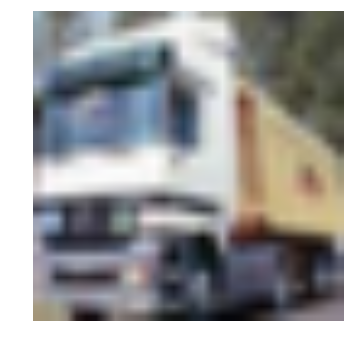

In [3]:
import cv2
import numpy as np
%matplotlib inline

imagen =  X_train[1,:,:,:]

#It's necesary to transform the image to the correct form to be plotted with imshow
print(imagen.shape)
#imagen= np.swapaxes(imagen,0,2)

#Roll axis to carry the image to the apropiated form - the axis to rotate depend of the organization of the data, for example for tensorflow are other axis to rotate.
imagen= np.rollaxis(imagen,0,3)
print(imagen.shape)

plt.axis("off")
plt.imshow(imagen)
#plt.imshow(imagen ,cmap='gray')

plt.show()

In [3]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 30, 30, 32)    9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 30, 30, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [4]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
             # verbose=1,
              validation_data=(X_test, Y_test),
              shuffle=True)   
    print('fit end.')

else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    print('stardr fit .')

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train)
    print('start generator.')

    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(X_train, Y_train,
                        batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_test, Y_test))
    

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 24s - loss: 2.3034 - acc: 0.1008 - val_loss: 2.3034 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 24s - loss: 2.3035 - acc: 0.0994 - val_loss: 2.3034 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 24s - loss: 2.3034 - acc: 0.0998 - val_loss: 2.3031 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 24s - loss: 2.3034 - acc: 0.0987 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 24s - loss: 2.3034 - acc: 0.1004 - val_loss: 2.3031 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 24s - loss: 2.3033 - acc: 0.0993 - val_loss: 2.3035 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 24s - loss: 2.3033 - acc: 0.1002 - val_loss: 2.3035 - val_acc: 0.1000
Epoch 8/20
50000/50000 [=